# Dependencies

In [41]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, save, load
from termcolor import colored
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Adding GPU if Supported

In [42]:
print("Whether CUDA is supported by our system:", torch.cuda.is_available())

print(f"CUDA version: {torch.version.cuda}") 

# Storing ID of current CUDA device 

cuda_id = torch.cuda.current_device() 

print(f"ID of current CUDA device:{torch.cuda.current_device()}") 

print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Whether CUDA is supported by our system: True
CUDA version: 11.7
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce GTX 1650 Ti


In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # use 'cuda:2' for 2 gpu's

# Get data 

In [44]:
train = datasets.MNIST(root="data", download=True, train=True, transform=ToTensor())
dataset = DataLoader(train, 32)
#1,28,28 - classes 0-9

# Image Classifier Neural Network

In [45]:
class ImageClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(64, 64, (3,3)), 
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(64*(28-6)*(28-6), 10)  
        )

    def forward(self, x): 
        return self.model(x)


# Instance of the neural network, loss, optimizer 

In [46]:
clf = ImageClassifier().to(device)
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss() 

# Training flow 

In [47]:
for epoch in range(10): # train for 10 epochs
    for batch in dataset: 
        X,y = batch 
        X, y = X.to(device), y.to(device) 
        yhat = clf(X) 
        loss = loss_fn(yhat, y) 

        # Apply backprop 
        opt.zero_grad()
        loss.backward() 
        opt.step() 

    print(f"Epoch: {epoch} loss is {loss.item()}")
    
with open('model_state.pt', 'wb') as f: 
    save(clf.state_dict(), f) 

Epoch: 0 loss is 0.03021545521914959
Epoch: 1 loss is 0.0033070880454033613
Epoch: 2 loss is 0.0010009255493059754
Epoch: 3 loss is 0.0005111894570291042
Epoch: 4 loss is 1.6065832824097015e-05
Epoch: 5 loss is 7.955674664117396e-05
Epoch: 6 loss is 1.6916903405217454e-05
Epoch: 7 loss is 0.002148501807823777
Epoch: 8 loss is 1.0430679822093225e-06
Epoch: 9 loss is 0.014051794074475765


# Testing

In [48]:
with open('model_state.pt', 'rb') as f: 
    clf.load_state_dict(load(f)) 

img1 = Image.open('img_1.jpg') 
img1_tensor = ToTensor()(img1).unsqueeze(0).to(device)
print("Input: img_1")
print("Output:" + colored(torch.argmax(clf(img1_tensor)), 'green', attrs=['bold']))

img2 = Image.open('img_2.jpg') 
img2_tensor = ToTensor()(img2).unsqueeze(0).to(device)
print("Input: img_2")
print("Output:" + colored(torch.argmax(clf(img2_tensor)), 'green', attrs=['bold']))

img3 = Image.open('img_3.jpg') 
img3_tensor = ToTensor()(img3).unsqueeze(0).to(device)
print("Input: img_3")
print("Output:" + colored(torch.argmax(clf(img3_tensor)), 'green', attrs=['bold']))

Input: img_1
Output:tensor(2, device='cuda:0')
Input: img_2
Output:tensor(0, device='cuda:0')
Input: img_3
Output:tensor(9, device='cuda:0')


           Image


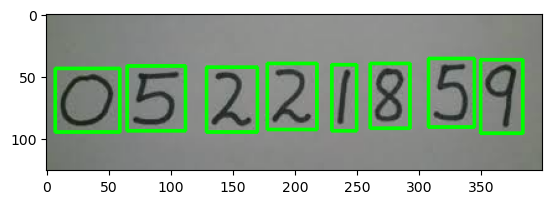

In [49]:
image = cv2.imread('img.jpeg')
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
preprocessed_digits = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    
    # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
    cv2.rectangle(image, (x-5,y-5), (x+w+5, y+h+5), color=(0, 255, 0), thickness=2)
    
    # Cropping out the digit from the image corresponding to the current contours in the for loop
    digit = thresh[y-5:y+h+5, x-5:x+w+5]
    
    # Resizing that digit to (18, 18)
    resized_digit = cv2.resize(digit, (18,18))
    
    # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
    padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)
    
    # Adding the preprocessed digit to the list of preprocessed digits
    preprocessed_digits.append(padded_digit)
print("           Image")
plt.imshow(image, cmap="gray")
plt.show()
    
inp = np.array(preprocessed_digits)

Prediction
Input image ↓ 


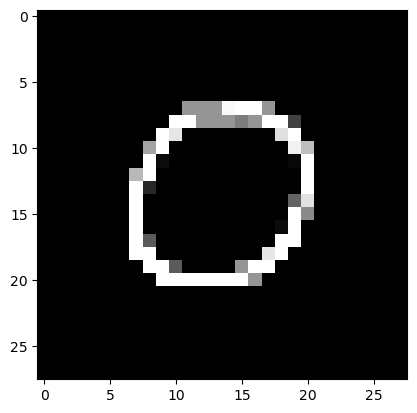

Output: tensor(0, device='cuda:0')
-------------------------------------------------------
Prediction
Input image ↓ 


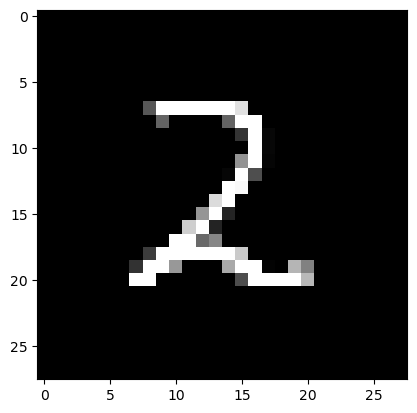

Output: tensor(2, device='cuda:0')
-------------------------------------------------------
Prediction
Input image ↓ 


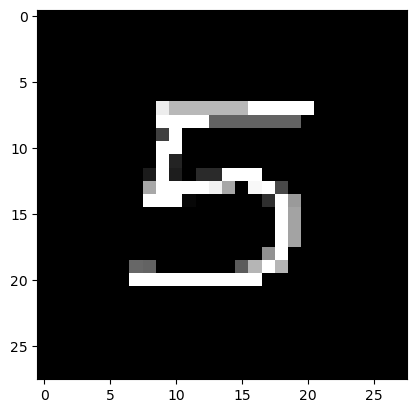

Output: tensor(5, device='cuda:0')
-------------------------------------------------------
Prediction
Input image ↓ 


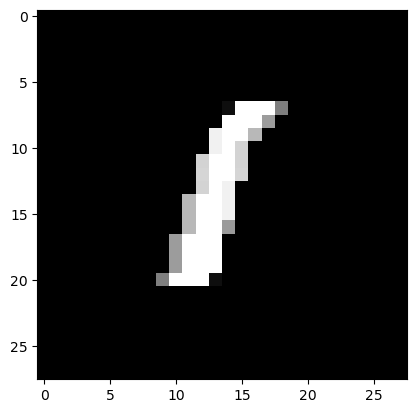

Output: tensor(1, device='cuda:0')
-------------------------------------------------------
Prediction
Input image ↓ 


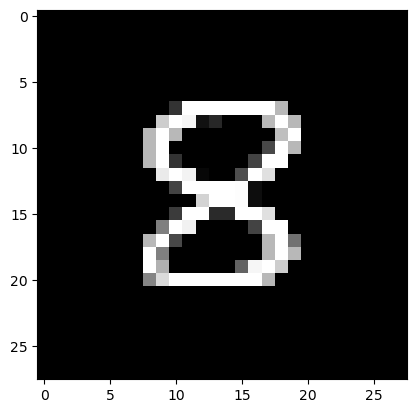

Output: tensor(8, device='cuda:0')
-------------------------------------------------------
Prediction
Input image ↓ 


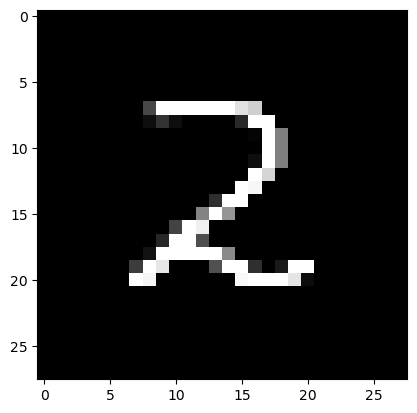

Output: tensor(2, device='cuda:0')
-------------------------------------------------------
Prediction
Input image ↓ 


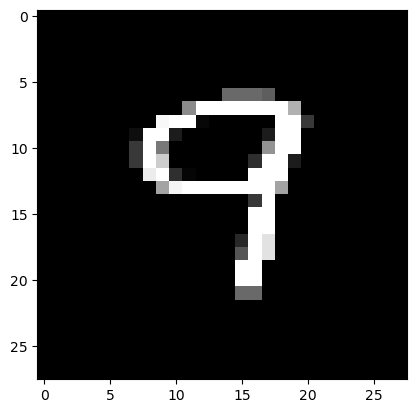

Output: tensor(9, device='cuda:0')
-------------------------------------------------------
Prediction
Input image ↓ 


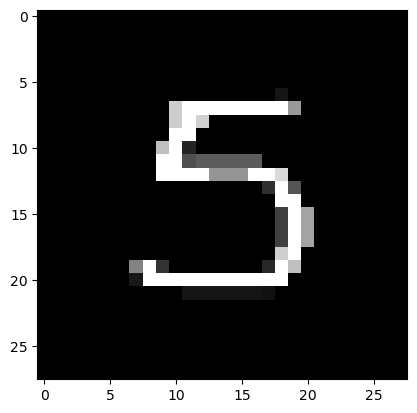

Output: tensor(5, device='cuda:0')
-------------------------------------------------------


In [50]:
with open('model_state.pt', 'rb') as f: 
    clf.load_state_dict(load(f)) 

for digit in preprocessed_digits:
    prediction = ToTensor()(digit).unsqueeze(0).to(device)
    print(colored("Prediction", 'blue', attrs=['bold']))
    print(colored("Input image ↓ ", 'yellow', attrs=['bold']))
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()
    print("Output: " + colored(torch.argmax(clf(prediction)), 'green', attrs=['bold']))
    print("-------------------------------------------------------")